$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{Universidad de los Andes}$$
$$\textrm{Grupo de Física de Altas Energías: Fenomenología de Partículas}$$

$\textbf{NOTA: Para importar este cuaderno de Jupyter desde otro es necesario usar los comandos 'import nbimporter' y 'import Analisis_mapas_de_calor'}$

$\textbf{Preliminares}$ 

Las librerías que se usan aquí son las siguientes: 

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

En este documento se definen funciones que buscan facilitar el análisis de los mapas de calor asociados a DataFrames que están guardados en un excel

$\textbf{Funciones}$

In [2]:
def read_excel(path, index_colum = 0):
    ''' Descripción: Esta función recibe una ruta de un archivo de excel y retorna el DataFrame que contiene dicho archivo.
    
    - path: ruta del archivo de excel (archivo terminado en .xlsx)
    - index_colum: columna de la tabla que contiene los index del DataFrame (por default es la columna 0)
    '''

    data = pd.read_excel(path, index_col = index_colum)
    data.sort_index(level=0, ascending=False, inplace=True)
    
    return data

In [3]:
def suavizar(Data, log = False):
    
    ''' Descripción: Esta función recibe una matriz de datos e interpolar los datos para retornar un DataFrame más grande y continuo
        
    - Data*: Matriz con los datos, cada entrada hace referencia al valor de una variable en función de los valores de columna y filas. Por ejemplo, si consideramos dos variables independientes A, B y una función F(A,B), Data es una matriz donde las filas toman los valores de A y las columnas los valores de B, es decir que cada entrada de la matriz será simplemente F(A,B
    - log: Boolean que dice si debemos trabajar en escala logaritmica (base 10) los dato.
    '''
    
    index = Data.index #Etiquetas de las columnas del DataFrame
    columns = Data.columns #Etiquetas de las filas del DataFrame
        
    if log: #Si el usuario ingresa log = True, entonces la etiqueta de la barra debe decir log y también debe sacarse el log a los datos.
        Data = np.log10(Data)
    
    #Para poder aplicar griddata (función de scipy que permite interpolar) es necesario reescribir los datos de una matriz en un formato de tres columnas. En lugar de tener una matriz donde, evaluar la función segun corresponda la fila y columna, es mejor reescribir todo en un formato de tres columnas. Simplemente: A, B, F(A,B). Esto es lo que hace el siguiente código:
    
    matriz = np.zeros([len(columns)*len(index),3])
    columna_0 = []
    for i in range(len(columns)):
        for j in range(len(index)):
            columna_0.append(columns[i])

    columna_1 = []
    for j in range(len(columns)):
        for i in range(len(index)):
            columna_1.append(index[i])

    matriz[:,0] = columna_0
    matriz[:,1] = columna_1

    for k in range(len(matriz[:,2])):
        matriz[k,2] = Data[matriz[k,0]][matriz[k,1]]

    Data = pd.DataFrame(matriz) #Se redefine los datos usando la estructura anteriormente explicada
    Data.columns = ["A", "B", "F(A,B)"] #Formato de tres columnas, se puede pensar como si fueran dos variables independientes A, B y una función F(A,B)
    
    #En este punto los datos ya se pueden leer facilmente, ahora lo que se debe hacer es crear los valores de x que queremos interpolar, es decir, los intervalos continuos que queremos interpolar, estos los llamaré "x" y "y". Sin embargo, debe tenerse en cuenta el caso en que una variable esta fija y solo la otra toma distintos valores, esto es lo que representan los len(--) == 1:
    
    if(len(columns) == 1):
        x = columns #x tiene un valor fijo
    else:
        x = np.linspace(np.min(Data['A']),np.max(Data['A']),500) #x toma un rango de valores
    
    if(len(index) == 1):
        y = index #y tiene un valor fijo
    else:
        y = np.linspace(np.min(Data['B']),np.max(Data['B']),500) #y tiene un rango de valores
    
    #En este punto ya se tienen "x" y "y", ahora debemos combinarlos para tener en cuenta todas las combinaciones, esto lo hace np.meshgrid:    
    gridx, gridy = np.meshgrid(x,y)
    
    #Finalmente bastaría interpolar usando como base nuestros datos; no obstante, hay que tener en cuenta tres casos
    
    if (len(columns) == 1):
        Data_interpolada = griddata(Data['B'].values, Data['F(A,B)'].values, y, method='cubic') #interpolación con x fijo
        Data_interpolada = pd.DataFrame(Data_interpolada)           
        Data_interpolada.index = y
        Data_interpolada.columns = x
        
    elif (len(index) == 1):
        Data_interpolada = griddata(Data['A'].values, Data['F(A,B)'].values, x , method='cubic') #interpolación con y fijo
        Data_interpolada = pd.DataFrame(Data_interpolada)
        Data_interpolada.index = x
        Data_interpolada.columns = y
        Data_interpolada = Data_interpolada.T #griddata siempre retorna en forma de vector columna, pero si en este caso y esta fijo, nuestros datos deben estar en formato de vector fila, eso hace el .T, saca la transpuesta.
    else:
        
        Data_interpolada = griddata((Data['A'].values,Data['B'].values), Data['F(A,B)'].values, (gridx,gridy), method='cubic')
        Data_interpolada = pd.DataFrame(Data_interpolada)
        Data_interpolada.index = y
        Data_interpolada.columns = x
            
    Data_interpolada.sort_index(level=0, ascending=False, inplace=True) #Permite que en la grafica se vea el eje y creciendo hacia arriba
    
    return Data_interpolada

In [4]:
def heatmap(Data, curvas_de_nivel = {}, zoom = {}, PDF_name = '', color = 'viridis', titulos = {'titulo': 'Titulo Grafica','x_label': 'eje x', 'y_label': 'eje y', 'cbar_label': 'barra de color'}):

    ''' Descripción: Esta función grafica el mapa de calor de un DataFrame. En adición a esto, también grafica curvas de nivel y hace zooms si es necesario.
    
    - curvas_de_nivel: Directorio que contiene las curvas de nivel que se desean graficar 
    - x_label: titulo del eje x de la grafica
    - y_label: titulo del eje y de la grafica
    - cbar_label: titulo de la barra de color, es decir, nombre de la cantidad que corresponde a cada entrada de la matriz. '''

    fig, ax = plt.subplots()
    plt.title(titulos['titulo'])
    
    index = Data.index
    columns = Data.columns
    
    if(len(index) == 1 or len(columns) == 1):
        sns.heatmap(Data, cmap = color, cbar_kws={'label': titulos['cbar_label']}).set(xlabel= titulos['x_label'], ylabel= titulos['y_label'])
        
    else:
        mapa_calor = plt.pcolormesh(columns, index, Data.values, cmap = color)
        plt.colorbar(mapa_calor, label = titulos['cbar_label'])  
    
        plt.xlabel(titulos['x_label'])
        plt.ylabel(titulos['y_label'])
    
    #Dependiendo la forma de los datos las curvas se hacen diferente, en el caso en que una de las dos variables independientes este fija entonces no se puede usar la función contour de matplotlib por la dimensión de dicha variable, en ese caso es necesario graficar asintotas.

    if (len(list(curvas_de_nivel.keys())) != 0):

        index = Data.index
        columns = Data.columns

        if(len(index) == 1):
            linestyles = ['-', '--', '-.', ':', '']
            for i in range(len(list(curvas_de_nivel.keys()))):
                curva = list(curvas_de_nivel.keys())[i]
                indice = np.abs(np.asarray(Data - curva)).argmin()
                ax.axvline(indice, label = curvas_de_nivel[curva], ls = linestyles[i % 5], color = 'white') #Asintota para cada curva con y fijo
            ax.legend()

        elif(len(columns) == 1):
            linestyles = ['-', '--', '-.', ':', '']
            for i in range(len(list(curvas_de_nivel.keys()))):
                curva = list(curvas_de_nivel.keys())[i]
                indice = np.abs(np.asarray(Data - curva)).argmin()
                ax.axhline(indice, label = curvas_de_nivel[curva], ls = linestyles[i % 5], color = 'white') #Asintota para cada curva con x fijo
            ax.legend()
            
        else:
            curves = plt.contour(Data.columns, Data.index, Data.values, levels = list(sorted(curvas_de_nivel.keys())), colors = ['white'], linestyles = 'dashed') #Curvas de nivel
            ax.clabel(curves, curves.levels, inline=True, fmt = curvas_de_nivel, fontsize=10, rightside_up = True) #Letreros de las curvas de nivel

    if (len(list(zoom.keys())) != 0):
        
        if (len(index) == 1 or len(columns) == 1): print('No es posible hacer zoom por las dimensiones del DataFrame')
        
        else:
        
            ax_zoom = ax.inset_axes([1.4, 0, 1, 1])
            
            ax_zoom.pcolormesh(Data.columns, Data.index, Data.values, cmap = color)
            
            if (len(list(curvas_de_nivel.keys())) != 0): ax_zoom.contour(Data.columns, Data.index, Data.values, levels = list(sorted(curvas_de_nivel.keys())), colors = ['white'], linestyles = 'dashed') #Curvas de nivel

            ax_zoom.set_xlim(zoom['x1'], zoom['x2'])
            ax_zoom.set_ylim(zoom['y1'], zoom['y2'])
            ax_zoom.set_xlabel(titulos['x_label'])
            ax_zoom.set_ylabel(titulos['y_label'])

            ax.indicate_inset_zoom(ax_zoom, edgecolor= "black")
            
    if (PDF_name != ''): plt.savefig(PDF_name, dpi=600, bbox_inches='tight')
    
    plt.show()

$\textbf{Ejemplos sobre el uso de estas funciones}$ 

In [44]:
N = 100
Datasets_Gustavo = {}

#trazas=np.linspace(1.26,1400,N)
#valores = np.linspace(50,1000,N)
#masas = np.linspace(0.250,80.0,N)
trazas=np.linspace(1.26,1400,N)
valores = np.linspace(50,1000,N)
masas = np.linspace(0.0005,0.05,N)

for i in range(N):
    
   # path_masa = f"M_EXCEL/M_{str(round(float(masas[i]),2)).replace('.','_')}.xlsx"
    path_traza = f"Tr_EXCEL/Tr_{str(round(float(trazas[i]),2)).replace('.','_')}.xlsx"
    path_fshort = f"fshort_EXCEL/f_{str(round(float(valores[i]),2)).replace('.','_')}.xlsx"
    path_bajamasa=f"fbajamasa_EXCEL/f_{str(round(float(valores[i]),2)).replace('.','_')}.xlsx"
    path_trazashort = f"Trshort_EXCEL/Trshort_{str(round(float(trazas[i]),2)).replace('.','_')}.xlsx"


    #Datasets_Gustavo[path_masa] = read_excel(path_masa)
    Datasets_Gustavo[path_traza] = read_excel(path_traza)
    #Datasets_Gustavo[path_f] = read_excel(path_f)
    Datasets_Gustavo[path_bajamasa]=read_excel(path_bajamasa)
    Datasets_Gustavo[path_trazashort] = read_excel(path_trazashort)
    Datasets_Gustavo[path_fshort]= read_excel(path_fshort)


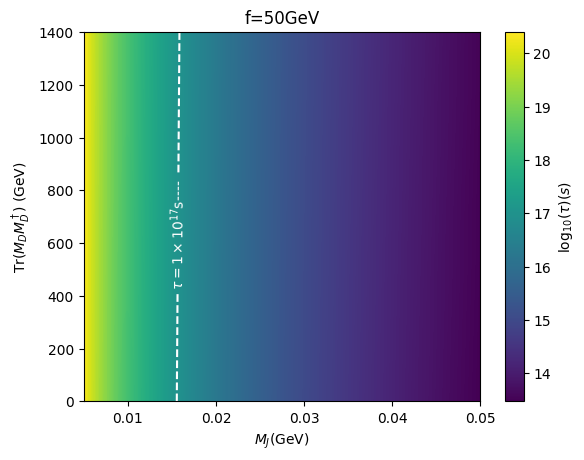

In [33]:
curvas = {17:r'$\tau=1\times 10^{17}$s----'}
data_int = suavizar(Datasets_Gustavo['fbajamasa_EXCEL/f_50_0.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='flowmass_50.png', curvas_de_nivel=curvas, titulos={'titulo':'f=50GeV', 'x_label':r'$M_J$(GeV)', 'y_label':r'Tr$(M_DM_D^\dagger)$ (GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('flowmass_50.png', dpi=300, bbox_inches='tight')

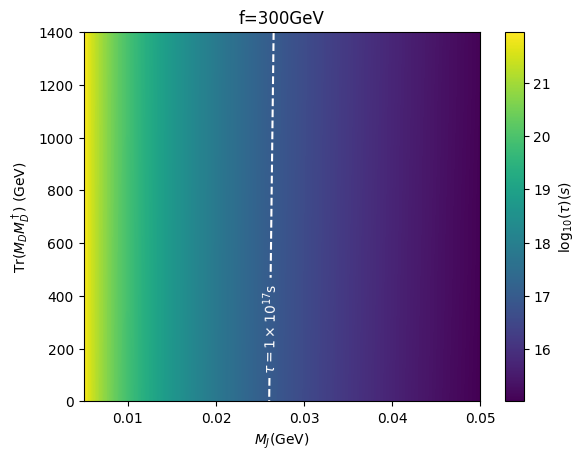

In [34]:
curvas = {17:r'$\tau=1\times 10^{17}$s'}
data_int = suavizar(Datasets_Gustavo['fbajamasa_EXCEL/f_299_49.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='flowmass_300.png', curvas_de_nivel=curvas, titulos={'titulo':'f=300GeV', 'x_label':r'$M_J$(GeV)', 'y_label':r'Tr$(M_DM_D^\dagger)$ (GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('flowmass_300.png', dpi=300, bbox_inches='tight')

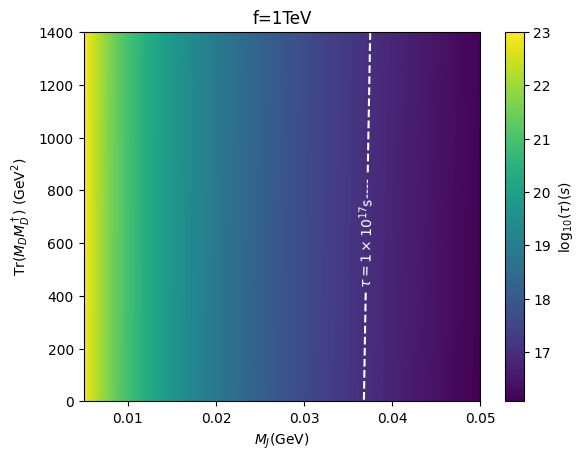

In [35]:
curvas = {17:r'$\tau=1\times 10^{17}$s----'}
data_int = suavizar(Datasets_Gustavo['fbajamasa_EXCEL/f_1000_0.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='flowmass_1000.png', curvas_de_nivel=curvas, titulos={'titulo':'f=1TeV', 'x_label':r'$M_J$(GeV)', 'y_label':r'Tr$(M_DM_D^\dagger)$ (GeV$^2$)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('flowmass_1000.png', dpi=300, bbox_inches='tight')

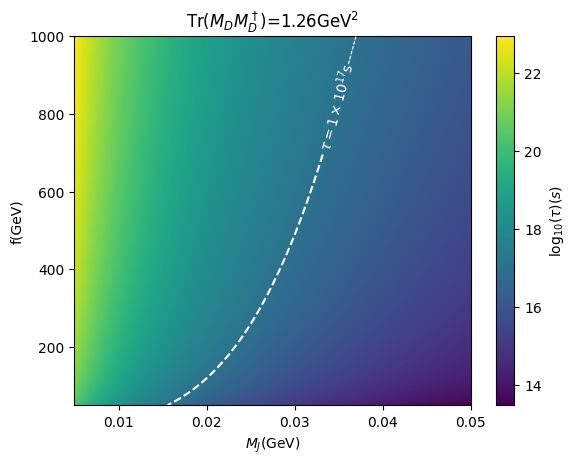

In [36]:
curvas = {17:r'$\tau=1\times 10^{17}$s-----------'}
data_int = suavizar(Datasets_Gustavo['Tr_EXCEL/Tr_1_26.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='Trlowmass_1p26.png', curvas_de_nivel=curvas, titulos={'titulo':r'Tr$(M_D M_D^\dagger)$=1.26GeV$^2$', 'x_label':r'$M_J$(GeV)', 'y_label':r'f(GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trlowmass_1p26.png', dpi=300, bbox_inches='tight')

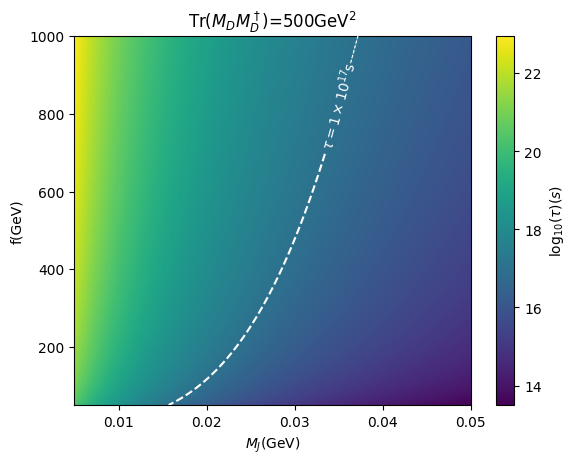

In [42]:
curvas = {17:r'$\tau=1\times 10^{17}$s-----------'}
data_int = suavizar(Datasets_Gustavo['Tr_EXCEL/Tr_509_89.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='Trlowmass_500.png', curvas_de_nivel=curvas, titulos={'titulo':r'Tr$(M_D M_D^\dagger)$=500GeV$^2$', 'x_label':r'$M_J$(GeV)', 'y_label':r'f(GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})

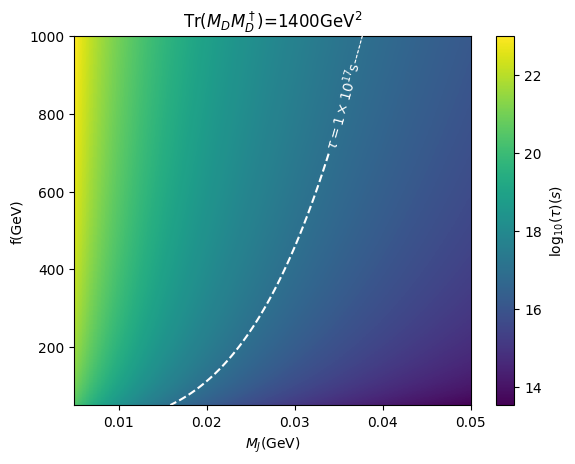

In [43]:
curvas = {17:r'$\tau=1\times 10^{17}$s-----------'}
data_int = suavizar(Datasets_Gustavo['Tr_EXCEL/Tr_1400_0.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='Trlowmass_1400.png', curvas_de_nivel=curvas, titulos={'titulo':r'Tr$(M_D M_D^\dagger)$=1400GeV$^2$', 'x_label':r'$M_J$(GeV)', 'y_label':r'f(GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})

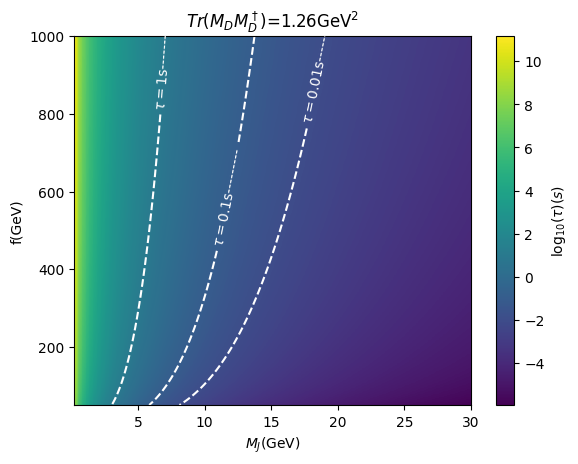

In [38]:
curvas = {1:r'$\tau=1$s---------', -1:r'$\tau=0.1$s---------', -2:r'$\tau=0.01$s---------'}
data_int = suavizar(Datasets_Gustavo['Trshort_EXCEL/Trshort_1_26.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name= 'Trsecond_1p26.png', curvas_de_nivel=curvas, titulos={'titulo':r'$Tr(M_D M_D^\dagger)$=1.26GeV$^2$', 'x_label':r'$M_J$(GeV)', 'y_label':'f(GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trsecond_1p26.png', dpi=300, bbox_inches='tight')

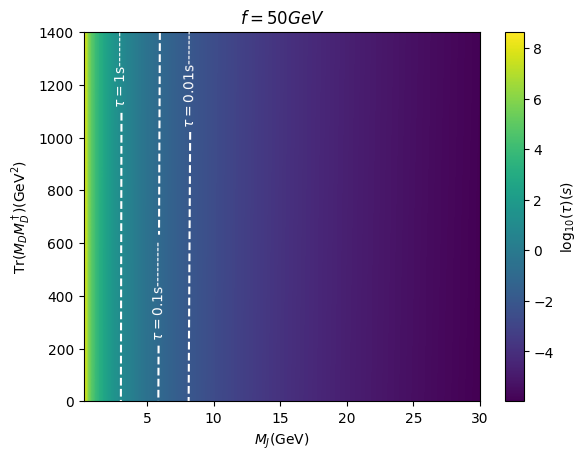

In [45]:
curvas = {1:r'$\tau=1$s---------', -1:r'$\tau=0.1$s---------', -2:r'$\tau=0.01$s---------'}
data_int = suavizar(Datasets_Gustavo['fshort_EXCEL/f_50_0.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name= 'fsecond_50.png', curvas_de_nivel=curvas, titulos={'titulo':r'$f=50 GeV$', 'x_label':r'$M_J$(GeV)', 'y_label':r'Tr$(M_D M_D^\dagger)$(GeV$^2$)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trsecond_1p26.png', dpi=300, bbox_inches='tight')

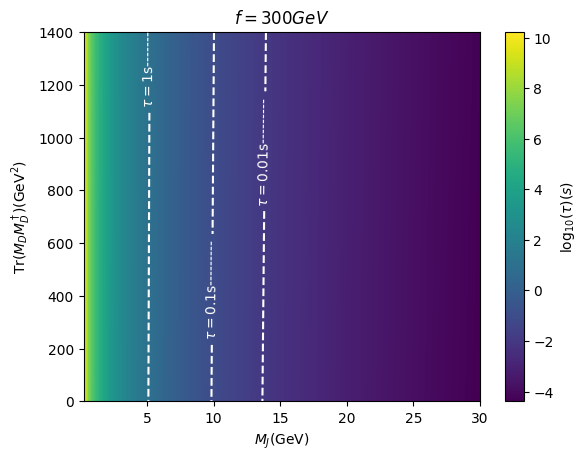

In [48]:
curvas = {1:r'$\tau=1$s---------', -1:r'$\tau=0.1$s---------', -2:r'$\tau=0.01$s---------'}
data_int = suavizar(Datasets_Gustavo['fshort_EXCEL/f_309_09.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name= 'fsecond_300.png', curvas_de_nivel=curvas, titulos={'titulo':r'$f=300 GeV$', 'x_label':r'$M_J$(GeV)', 'y_label':r'Tr$(M_D M_D^\dagger)$(GeV$^2$)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trsecond_1p26.png', dpi=300, bbox_inches='tight')

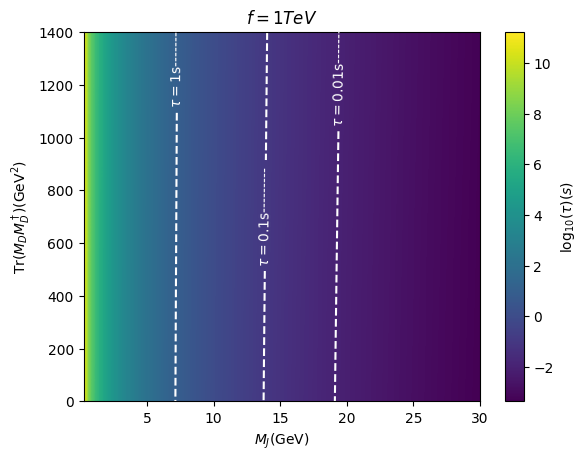

In [49]:
curvas = {1:r'$\tau=1$s---------', -1:r'$\tau=0.1$s---------', -2:r'$\tau=0.01$s---------'}
data_int = suavizar(Datasets_Gustavo['fshort_EXCEL/f_1000_0.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name= 'fsecond_1000.png', curvas_de_nivel=curvas, titulos={'titulo':r'$f=1 TeV$', 'x_label':r'$M_J$(GeV)', 'y_label':r'Tr$(M_D M_D^\dagger)$(GeV$^2$)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trsecond_1p26.png', dpi=300, bbox_inches='tight')

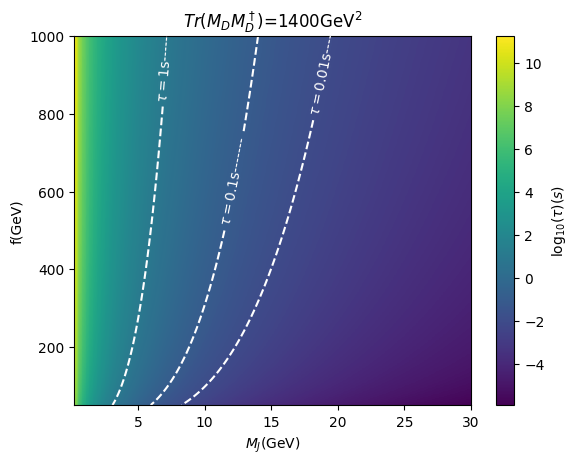

In [41]:
curvas = {1:r'$\tau=1$s-------', -1:r'$\tau=0.1$s-------', -2:r'$\tau=0.01$s-------'}
data_int = suavizar(Datasets_Gustavo['Trshort_EXCEL/Trshort_1400_0.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='Trsecond_1400.png', curvas_de_nivel=curvas, titulos={'titulo':r'$Tr(M_D M_D^\dagger)$=1400GeV$^2$', 'x_label':r'$M_J$(GeV)', 'y_label':'f(GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trsecond_1400.png', dpi=300, bbox_inches='tight')

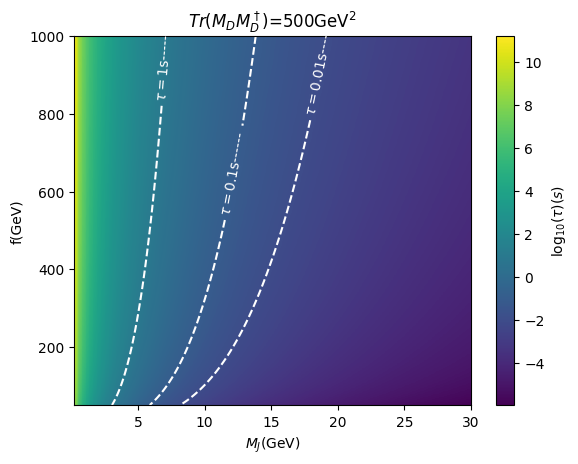

In [40]:
curvas = {1:r'$\tau=1$s-------', -1:r'$\tau=0.1$s------', -2:r'$\tau=0.01$s-------'}
data_int = suavizar(Datasets_Gustavo['Trshort_EXCEL/Trshort_495_76.xlsx'], log = True)
mapa=heatmap(data_int, PDF_name='Trsecond_500.png', curvas_de_nivel=curvas, titulos={'titulo':r'$Tr(M_D M_D^\dagger)$=500GeV$^2$', 'x_label':r'$M_J$(GeV)', 'y_label':'f(GeV)', 'cbar_label':r'log$_{10}(\tau) (s)$'})
#plt.savefig('Trsecond_500.png', dpi=300, bbox_inches='tight')